## Решение задачи

Установим Optuna, которая автоматизирует настройку гиперпараметров:

In [ ]:
!pip install optuna

Импортируем необходимые библиотеки:

In [ ]:
import numpy as np
import pandas as pd
from keras import utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1, l2, l1_l2
from keras.activations import relu, elu, selu, tanh
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from sklearn.model_selection import train_test_split

%matplotlib inline

Скачаем необходимый датасет для решения задачи:

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2025-05-22 09:50:24--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv.2’

japan_cars_dataset. 100%[===================>] 133.53K   236KB/s    in 0.6s    

2025-05-22 09:50:26 (236 KB/s) - ‘japan_cars_dataset.csv.2’ saved [136735/136735]



Выведем в виде таблицы наш датасет, а также удалим строки с пустыми значениями и дубликаты:

In [ ]:
df = pd.read_csv('japan_cars_dataset.csv', on_bad_lines='skip', low_memory=False, sep=',')
df = df.dropna() #удаление строк с пустыми значениями
df = df.drop_duplicates() #удаляем дубликаты
df.head(10)

,Unnamed: 0,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
0,0,80,nissan,march,2003,80000,1240,at,2wd,rhd,gasoline
1,1,110,nissan,march,2010,53000,1200,at,2wd,rhd,gasoline
2,2,165,nissan,lafesta,2005,47690,2000,at,2wd,rhd,gasoline
3,3,190,toyota,avensis,2008,130661,1990,at,2wd,rhd,gasoline
4,4,190,daihatsu,mira,2006,66300,660,at,2wd,rhd,gasoline
5,5,190,daihatsu,mira,2004,81400,660,at,2wd,rhd,gasoline
6,8,220,nissan,march,2010,117000,1200,at,2wd,rhd,gasoline
7,9,230,volkswagen,passat,2008,127763,3190,at,4wd,rhd,gasoline
8,10,275,mazda,bongo van,2010,178218,1800,mt,2wd,rhd,gasoline
9,11,283,honda,step wgn,2005,121655,2000,at,2wd,rhd,gasoline


Удалим ненужный столбец:

In [ ]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)

Узнаем более подробную информацию о уже измененном нами датасете:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   price            2318 non-null   int64 
 1   mark             2318 non-null   object
 2   model            2318 non-null   object
 3   year             2318 non-null   int64 
 4   mileage          2318 non-null   int64 
 5   engine_capacity  2318 non-null   int64 
 6   transmission     2318 non-null   object
 7   drive            2318 non-null   object
 8   hand_drive       2318 non-null   object
 9   fuel             2318 non-null   object
dtypes: int64(4), object(6)
memory usage: 181.2+ KB


Выведем произвольный пример и внимательно изучим данные представленного образца:

In [ ]:
n = 3
for i in range(len(df.values[n])):
    print('{:>2} {:>30}  {}'.format(i, df.columns[i], df.values[n][i]))

 0                          price  190
 1                           mark  toyota
 2                          model  avensis
 3                           year  2008
 4                        mileage  130661
 5                engine_capacity  1990
 6                   transmission  at
 7                          drive  2wd
 8                     hand_drive  rhd
 9                           fuel  gasoline


Произведем удаление выбросов среди числовых признаков, установив нижнюю и верхнюю границу.

Далее преобразуем цены в логарифмическую шкалу для нормализации распределения. Это помогает уменьшить влияние экстремальных значений и сделать данные более "нормальными".

Добавим новые признаки, которые будут улучшать сходимость с целевым признаком - ценой.` .fillna(0)` заменяет NaN на 0, `.replace(0, np.nan).fillna(1)` – защита от деления на ноль, `.transform()` нужен, чтобы добавить групповые статистики в исходный датафрейм, сохраняя его размер.

In [ ]:
#удаление выбросов по всем числовым признакам
numeric_cols = ['year', 'mileage', 'engine_capacity', 'price']
for col in numeric_cols:
    Q1 = df[col].quantile(0.15)
    Q3 = df[col].quantile(0.85)
    df = df[(df[col] >= Q1) & (df[col] <= Q3)]

df['price'] = np.log1p(df['price']) #логарифмирование цены для нормализации распределения

#добавляем новые признаки
df['mark_avg_price'] = df.groupby('mark')['price'].transform('mean')
df['mark_std_price'] = df.groupby('mark')['price'].transform('std').fillna(0)
df['mark_count'] = df.groupby('mark')['price'].transform('count')

df['model_avg_price'] = df.groupby('model')['price'].transform('mean')
df['model_std_price'] = df.groupby('model')['price'].transform('std').fillna(0)
df['model_count'] = df.groupby('model')['price'].transform('count')

df['fuel_avg_price'] = df.groupby('fuel')['price'].transform('mean')
df['fuel_std_price'] = df.groupby('fuel')['price'].transform('std').fillna(0)

df['price_to_mark_avg'] = df['price'] / df['mark_avg_price'].replace(0, np.nan).fillna(1)
df['price_to_model_avg'] = df['price'] / df['model_avg_price'].replace(0, np.nan).fillna(1)

df['age'] = 2025 - df['year']
df['mileage_ratio'] = df['mileage'] / df['mileage'].max()

Далее нам необходимо создать классы для марок автомобилей:

In [ ]:
mark_class = {
    'toyota': 0,
    'honda': 1,
    'nissan': 2,
    'daihatsu': 3,
    'volkswagen': 4,
    'mazda': 5,
    'mercedes-benz': 6,
    'mitsubishi': 7,
    'прочее': 8
}

Нейронные сети хорошо работают с данными представленными в формате **one hot encoding**, поэтому реализуем следующую функцию:

In [ ]:
def mark2OHE(param):
    num_classes = len(set(mark_class.values()))
    if not isinstance(param, str):
        param = list(mark_class.keys())[-1]
    split_array = re.split(r'[ ,.:()?!]', param.lower())
    for word in split_array:
        mark_cls = mark_class.get(word, -1)
        if mark_cls >= 0:
            break
    else:
        mark_cls = num_classes - 1
    return utils.to_categorical(mark_cls, num_classes)

Год, пробег и мощность двигателя мы также превратим в **one hot encoding** формат. Для этого зададим пороговые значения:

In [ ]:
year_class = [1979, 1981, 1983, 1985, 1987, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
mileage_class = [2000, 4000, 6000, 8000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 150000, 200000, 250000, 300000]
engine_capacity_class = [9, 100, 300, 500, 700, 900, 1100, 1300, 1500, 2000, 2300, 2700, 3000, 3400, 3700, 4200, 4600, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 10000, 11500, 13000]

Определим универсальную функцию перевода числа в диапазон **one hot encoding**:

In [ ]:
def range2OHE(param, class_list):
    num_classes = len(class_list)+1
    for i in range(num_classes - 1):
        if float(param) < class_list[i]:
            cls = i
            break
    else:
        cls = num_classes - 1
    return utils.to_categorical(cls, num_classes)

Далее для столбцов *model*, *transmission*, *drive*, *hand_drive* и *fuel* создидм словари, из которых получим классы для каждого столбца:

In [ ]:
model_class = {
    'fit': 0,
    'vitz': 1,
    'passo': 2,
    'ist': 3,
    'ractis': 4,
    'note': 5,
    'demio': 6,
    'wish': 7,
    'swift': 8,
    'march': 9,
    'sienta': 10,
    'raum': 11,
    'cube': 12,
    'прочее': 13
}

transmission_class = {
    'at': 0,
    'mt': 1,
    'прочее': 2
}

drive_class = {
    '2wd': 0,
    '4wd': 1,
    'прочее': 2
}

hand_drive_class = {
    'rhd': 0,
    'lhd': 1,
    'прочее': 2
}

fuel_class = {
    'gasoline': 0,
    'diesel': 1,
    'hybrid': 2,
    'lpg': 3,
    'прочее': 4
}

Определим универсальную функцию преобразования строки к *multi-вектору:*

In [ ]:
def str2multiOHE(param, class_dict):
    num_classes = len(class_dict)
    result = np.zeros(num_classes)
    if not isinstance(param, str):
        result[-1] = 1.0
        return result
    param = param.lower().strip()
    for value, cls in class_dict.items():
        if value in param:
            result[cls] = 1.0
    return result

Выполним фиксацию индексов столбцов, объединеним все входные данные в один общий вектор,где `x_data` — вектор признаков, `y_data` — целевое значение, т.е. цена. `get_train_data` -  функция, которая преобразует весь датафрейм в два массива NumPy.

In [ ]:
#фиксация индексов столбцов
COL_MARK = df.columns.get_loc('mark')
COL_MODEL = df.columns.get_loc('model')
COL_YEAR = df.columns.get_loc('year')
COL_MILEAGE = df.columns.get_loc('mileage')
COL_ENGINE_CAPACITY = df.columns.get_loc('engine_capacity')
COL_TRANSMISSION = df.columns.get_loc('transmission')
COL_DRIVE = df.columns.get_loc('drive')
COL_HAND_DRIVE = df.columns.get_loc('hand_drive')
COL_FUEL = df.columns.get_loc('fuel')
COL_PRICE = df.columns.get_loc('price')
COL_MARK_AVG_PRICE = df.columns.get_loc('mark_avg_price')
COL_MARK_STD_PRICE = df.columns.get_loc('mark_std_price')
COL_MARK_COUNT = df.columns.get_loc('mark_count')
COL_MODEL_AVG_PRICE = df.columns.get_loc('model_avg_price')
COL_MODEL_STD_PRICE = df.columns.get_loc('model_std_price')
COL_MODEL_COUNT = df.columns.get_loc('model_count')
COL_FUEL_AVG_PRICE = df.columns.get_loc('fuel_avg_price')
COL_FUEL_STD_PRICE = df.columns.get_loc('fuel_std_price')
COL_PRICE_TO_MARK_AVG = df.columns.get_loc('price_to_mark_avg')
COL_PRICE_TO_MODEL_AVG = df.columns.get_loc('price_to_model_avg')
COL_AGE = df.columns.get_loc('age')
COL_MILEAGE_RATIO = df.columns.get_loc('mileage_ratio')


def get_row_data(row):
    #объединение всех входных данных в один общий вектор
    x_data = np.hstack([
        mark2OHE(row[COL_MARK]),
        range2OHE(row[COL_YEAR], year_class),
        range2OHE(row[COL_MILEAGE], mileage_class),
        range2OHE(row[COL_ENGINE_CAPACITY], engine_capacity_class),
        str2multiOHE(row[COL_MODEL], model_class),
        str2multiOHE(row[COL_TRANSMISSION], transmission_class),
        str2multiOHE(row[COL_DRIVE], drive_class),
        str2multiOHE(row[COL_HAND_DRIVE], hand_drive_class),
        str2multiOHE(row[COL_FUEL], fuel_class),

        row[COL_MARK_AVG_PRICE],
        row[COL_MARK_STD_PRICE],
        row[COL_MARK_COUNT],
        row[COL_MODEL_AVG_PRICE],
        row[COL_MODEL_STD_PRICE],
        row[COL_MODEL_COUNT],
        row[COL_FUEL_AVG_PRICE],
        row[COL_FUEL_STD_PRICE],
        row[COL_PRICE_TO_MARK_AVG],
        row[COL_PRICE_TO_MODEL_AVG],
        row[COL_AGE],
        row[COL_MILEAGE_RATIO],
    ])
    y_data = np.array([row[COL_PRICE]])
    return x_data, y_data


def get_train_data(dataFrame):
    x_data = []
    y_data = []
    for row in dataFrame.values:
        x, y = get_row_data(row)
        x_data.append(x)
        y_data.append(y)
    return np.array(x_data), np.array(y_data)

x_all, y_all = get_train_data(df)

Формируем данные:

In [ ]:
x_all, y_all = get_train_data(df) #формирование всех данных

Разделим данные на обучающую (70%), тестовую (15%) и валидационную (15%) выборки. После выведем информацию о данных в каждой из них:

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x_all, y_all, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#вывод количества данных в каждой выборке
print("\nРаспределение данных:")
print(f"Обучающая выборка (train): {len(x_train)} примеров ({len(x_train)/len(x_all)*100:.1f}%)")
print(f"Валидационная выборка (val): {len(x_val)} примеров ({len(x_val)/len(x_all)*100:.1f}%)")
print(f"Тестовая выборка (test): {len(x_test)} примеров ({len(x_test)/len(x_all)*100:.1f}%)")
print(f"Общий размер датасета: {len(x_all)} примеров\n")


Распределение данных:
Обучающая выборка (train): 468 примеров (70.0%)
Валидационная выборка (val): 100 примеров (14.9%)
Тестовая выборка (test): 101 примеров (15.1%)
Общий размер датасета: 669 примеров



`StandardScaler() `— это метод из библиотеки sklearn. Он нормализует данные так, чтобы среднее значение было равно 0 , а стандартное отклонение — 1 .

In [ ]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

Данный блок кода оптимизирует архитектуру нашей модели с помощью **Optuna**. Обучаем модель с разными гиперпараметрами, чтобы найти наилучшие. Строим финальную модель на основе найденных параметров.


In [ ]:
def create_model(trial):
    #оптимизация архитектуры
    n_layers = trial.suggest_int('n_layers', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'selu', 'tanh'])

    #оптимизация регуляризации
    reg_type = trial.suggest_categorical('reg_type', ['l1', 'l2', 'l1_l2', 'none'])
    reg_strength = trial.suggest_float('reg_strength', 1e-5, 1e-2, log=True) if reg_type != 'none' else 0

    #инициализация регуляризатора
    regularizer = {
        'l1': l1(reg_strength),
        'l2': l2(reg_strength),
        'l1_l2': l1_l2(reg_strength, reg_strength),
        'none': None
    }[reg_type]

    #построение модели
    inputs = Input(shape=(x_train_scaled.shape[1],))
    x = inputs

    for i in range(n_layers):
        units = trial.suggest_int(f'n_units_l{i}', 64, 512, step=64)
        x = Dense(units, activation=activation, kernel_regularizer=regularizer)(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)

    #оптимизация параметров обучения
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    model = create_model(trial)

    history = model.fit(
        x_train_scaled,
        y_train_scaled,
        validation_data=(x_val_scaled, y_val_scaled),
        batch_size=batch_size,
        epochs=100,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    return min(history.history['val_loss'])

#запуск оптимизации
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)

input_layer = Input(shape=(x_train_scaled.shape[1],))
x = input_layer

#применяем лучшие параметры напрямую из study.best_params:
best_reg_type = study.best_params.get('reg_type', 'none')
best_reg_strength = study.best_params.get('reg_strength', 0) if best_reg_type != 'none' else 0

#инициализация регуляризатора на основе лучших параметров
best_regularizer = {
    'l1': l1(best_reg_strength),
    'l2': l2(best_reg_strength),
    'l1_l2': l1_l2(best_reg_strength, best_reg_strength),
    'none': None
}[best_reg_type]

for i in range(study.best_params['n_layers']):
    x = Dense(study.best_params[f'n_units_l{i}'],
              activation=study.best_params['activation'],
              kernel_regularizer=best_regularizer)(x)
    x = BatchNormalization()(x)
    x = Dropout(study.best_params['dropout_rate'])(x)

output_layer = Dense(1, activation='linear')(x)
best_model = Model(inputs=input_layer, outputs=output_layer)

[I 2025-05-22 09:50:26,765] A new study created in memory with name: no-name-dc953664-19c9-40a1-a474-381e5b1ee96e
[I 2025-05-22 09:50:54,038] Trial 0 finished with value: 0.2534252107143402 and parameters: {'batch_size': 128, 'n_layers': 2, 'dropout_rate': 0.4790082476934766, 'activation': 'selu', 'reg_type': 'l1', 'reg_strength': 3.681074097376431e-05, 'n_units_l0': 192, 'n_units_l1': 64, 'learning_rate': 4.110194844578074e-05}. Best is trial 0 with value: 0.2534252107143402.
[I 2025-05-22 09:51:08,418] Trial 1 finished with value: 0.19114254415035248 and parameters: {'batch_size': 128, 'n_layers': 1, 'dropout_rate': 0.20506717357880438, 'activation': 'elu', 'reg_type': 'l2', 'reg_strength': 0.001432964454117149, 'n_units_l0': 64, 'learning_rate': 0.00016605381039074127}. Best is trial 1 with value: 0.19114254415035248.
[I 2025-05-22 09:51:31,234] Trial 2 finished with value: 17.87096405029297 and parameters: {'batch_size': 64, 'n_layers': 3, 'dropout_rate': 0.4202639642308814, 'activ

Выполним компиляцию модели и приступим к обучению модели, сопоставив те параметры, которые были подобраны **Optuna**:

In [ ]:
best_model.compile(
    optimizer=Adam(learning_rate=study.best_params['learning_rate']),
    loss='mse',
    metrics=['mae']
)

print(f"Общий размер датасета: {len(x_all)} примеров")
print(f"Обучающая выборка: {len(x_train)} примеров ({len(x_train)/len(x_all)*100:.1f}%)")
print(f"Валидационная выборка: {len(x_val)} примеров ({len(x_val)/len(x_all)*100:.1f}%)")
print(f"Тестовая выборка: {len(x_test)} примеров ({len(x_test)/len(x_all)*100:.1f}%)")


history = best_model.fit(
    x_train_scaled,
    y_train_scaled,
    validation_data=(x_val_scaled, y_val_scaled),
    batch_size=study.best_params['batch_size'],
    epochs=300,
    verbose=1,
    callbacks=[
        EarlyStopping(patience=25, monitor='val_loss', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
    ],
    shuffle=True
)

Общий размер датасета: 669 примеров
Обучающая выборка: 468 примеров (70.0%)
Валидационная выборка: 100 примеров (14.9%)
Тестовая выборка: 101 примеров (15.1%)
Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 2.7533 - mae: 1.2980 - val_loss: 0.4243 - val_mae: 0.5192 - learning_rate: 0.0042
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9024 - mae: 0.8646 - val_loss: 0.3387 - val_mae: 0.4790 - learning_rate: 0.0042
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6118 - mae: 0.5940 - val_loss: 0.2688 - val_mae: 0.4377 - learning_rate: 0.0042
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3150 - mae: 0.4329 - val_loss: 0.2604 - val_mae: 0.4212 - learning_rate: 0.0042
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2979 - mae: 0.4258 - val_loss: 0.1529 - val_mae: 0.3259 - learning_rate: 0.0042
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2428 - mae: 0.3799 - val_loss: 0.1355 - val_mae: 0.3064 - learning_rate: 0

Построим график для отслеживания средней абсолютной ошибки на обучающей и проверочной выборках:

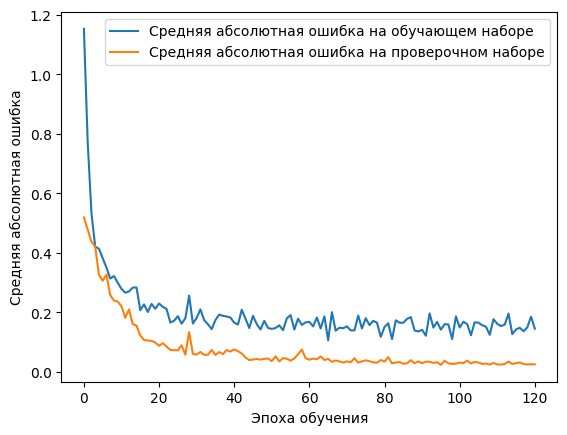

In [ ]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Выполним предсказание на валидационной выборке, реализуем обратное преобразование данных. Это делается для корректной оценки.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Средняя абсолютная процентная ошибка (MAPE) на валидационной выборке: 0.42%

Средняя абсолютная ошибка (MAE) на валидационной выборке: 4.18

Примеры предсказаний на валидационной выборке (первые 10 из 100):
Реальное:    1213.00 | Предсказанное:    1211.27 | Ошибка:       1.73
Реальное:     929.00 | Предсказанное:     921.67 | Ошибка:       7.33
Реальное:     780.00 | Предсказанное:     779.59 | Ошибка:       0.41
Реальное:     900.00 | Предсказанное:     895.79 | Ошибка:       4.21
Реальное:     831.00 | Предсказанное:     831.62 | Ошибка:       0.62
Реальное:     933.00 | Предсказанное:     930.39 | Ошибка:       2.61
Реальное:    1236.00 | Предсказанное:    1239.73 | Ошибка:       3.73
Реальное:     850.00 | Предсказанное:     855.24 | Ошибка:       5.24
Реальное:    1050.00 | Предсказанное:    1054.60 | Ошибка:       4.60
Реальное:    1200.00 | Предсказанное:    1197.91 | Ошибка:       2.09


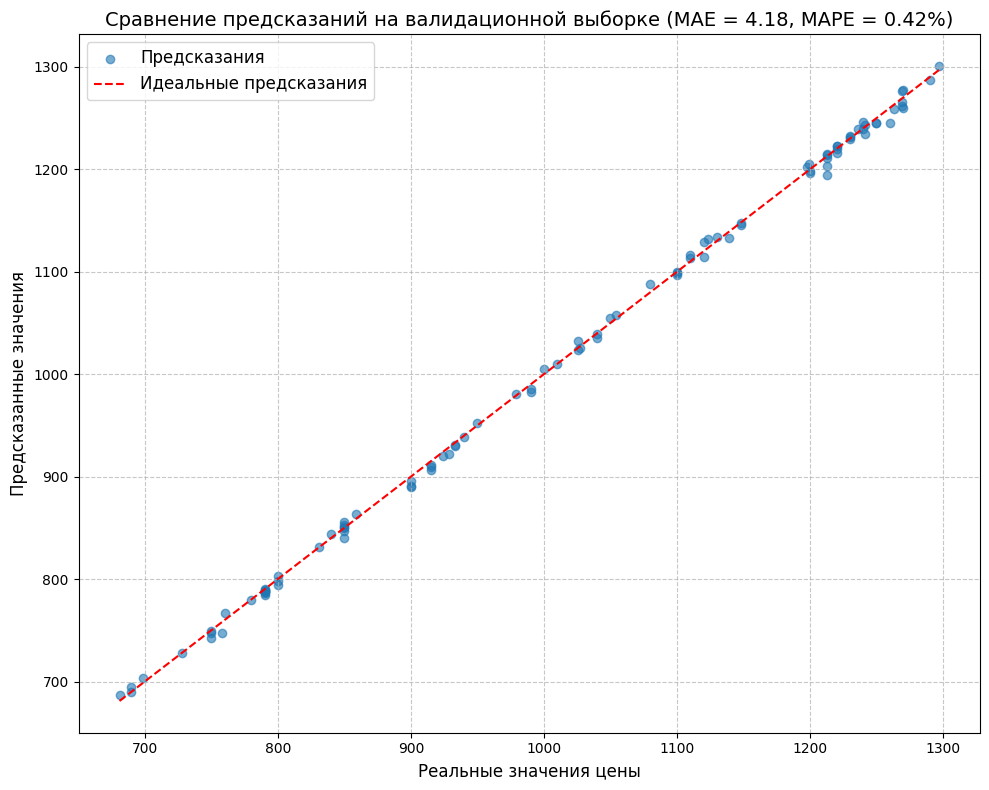

In [ ]:
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-10))) #добавляем небольшое значение к знаменателю, чтобы избежать деления на ноль

#предсказание на валидационной выборке вместо тестовой
pred_val = best_model.predict(x_val_scaled)
#обратное преобразование: сначала StandardScaler, затем expm1
pred_val = y_scaler.inverse_transform(pred_val)
pred_val = np.expm1(pred_val)
y_val_original = np.expm1(y_val)

mape_val = safe_mape(y_val_original, pred_val)
val_mae = mean_absolute_error(y_val_original, pred_val)

print(f"\nСредняя абсолютная процентная ошибка (MAPE) на валидационной выборке: {mape_val:.2f}%")
print(f"\nСредняя абсолютная ошибка (MAE) на валидационной выборке: {val_mae:.2f}\n")

np.random.seed(42)
random_indices = np.random.choice(len(y_val_original), size=100, replace=False)
y_val_sample = y_val_original[random_indices]
pred_val_sample = pred_val[random_indices]

print("Примеры предсказаний на валидационной выборке (первые 10 из 100):")
for i in range(10):
    print(f"Реальное: {y_val_sample[i, 0]:10.2f} | Предсказанное: {pred_val_sample[i, 0]:10.2f} | Ошибка: {abs(y_val_sample[i, 0] - pred_val_sample[i, 0]):10.2f}")

plt.figure(figsize=(10, 8))
plt.scatter(y_val_sample, pred_val_sample, alpha=0.6, label='Предсказания')
plt.plot([y_val_sample.min(), y_val_sample.max()],
         [y_val_sample.min(), y_val_sample.max()],
         'r--', label='Идеальные предсказания')
plt.xlabel('Реальные значения цены', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)
plt.title(f'Сравнение предсказаний на валидационной выборке (MAE = {val_mae:.2f}, MAPE = {mape_val:.2f}%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()